# Unlocking Church Growth: Data Insights from the National Congregations Study
# Staffing Analysis

## Objective
In this segment of the analysis we specifically explore the staffing features of the congregation and how they may impact an attendance change. The features included are:<br>
 - Building: The type of building used for the primary worship services (i.e., School, Storefront, Church/Synagogue/Temple/Mosque, or Other)
 - Artwork: identifies if visitors come to view the architecure, artwork, stained glass, or statues
 - Remodel: was there a remodel in recent years?
 - Founded: year the primary building was founded
 - Home School: are homeschool group(s) sponsored?
 - School: K-12 school onsite
 - Building Use: Other groups, programs or events not connected to the congeregation
 - Permits: permits or licenses are obtained (i.e., Kitchen, Remodeling, Liquor, Day Care, Bingo/Gambling/Raffle, Statue/Signage, Festival/Bazaar, Zoning, Tax Exemption, etc.)

## Data Preparation

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import itertools
from itertools import product

# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [5]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [6]:
# Select specific features
selected_columns = ['DENOM', 'FTSTAFF', 'PTSTAFF', 'FTSCHLD', 'PTSCHLD', 'FTSYOUTH', 'PTSYOUTH', 'FTSYA', 'PTSYA', 'FTSMUSIC', 'PTSMUSIC', 'FTSREDU', 'PTSREDU', 'FTSFAMIN', 'PTSFAMIN', 'FTSCARE', 'PTSCARE', 'FTSPSYCH', 'PTSPSYCH', 'FTSENGAG', 'PTSENGAG', 'FTSGROW', 'PTSGROW', 'FTSREACH', 'PTSREACH', 'FTSADMIN', 'PTSADMIN', 'FTSVOLC', 'PTSVOLC', 'FTSWTECH', 'PTSWTECH', 'FTSTECH', 'PTSTECH', 'FTSMEDIA', 'PTSMEDIA', 'change_category']
df_staffing = data[selected_columns].copy()

# Drop DENOM
df_staffing.drop(['DENOM'], axis=1, inplace=True)

In [7]:
# Replace NaN or missing values with 0 in all columns except categorial columns. Assumes no response = no staff in the position
columns_to_replace = [col for col in selected_columns if col not in ['DENOM', 'change_category']]
df_staffing[columns_to_replace] = df_staffing[columns_to_replace].fillna(0)

In [8]:
# One-Hot Encoding
categorical_columns = df_staffing.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_staffing[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
#df_facilities_encoded = pd.concat([df_facilities.reset_index(drop=True), encoded_df], axis=1)
df_staffing_encoded = pd.concat([df_staffing, encoded_df], axis=1)
df_staffing_encoded = df_staffing_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [9]:
# Basic exploration
df_staffing_encoded.info()
df_staffing_encoded.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FTSTAFF                   5333 non-null   float64
 1   PTSTAFF                   5333 non-null   float64
 2   FTSCHLD                   5333 non-null   float64
 3   PTSCHLD                   5333 non-null   float64
 4   FTSYOUTH                  5333 non-null   float64
 5   PTSYOUTH                  5333 non-null   float64
 6   FTSYA                     5333 non-null   float64
 7   PTSYA                     5333 non-null   float64
 8   FTSMUSIC                  5333 non-null   float64
 9   PTSMUSIC                  5333 non-null   float64
 10  FTSREDU                   5333 non-null   float64
 11  PTSREDU                   5333 non-null   float64
 12  FTSFAMIN                  5333 non-null   float64
 13  PTSFAMIN                  5333 non-null   float64
 14  FTSCARE 

,FTSTAFF,PTSTAFF,FTSCHLD,PTSCHLD,FTSYOUTH,PTSYOUTH,FTSYA,PTSYA,FTSMUSIC,PTSMUSIC,...,PTSVOLC,FTSWTECH,PTSWTECH,FTSTECH,PTSTECH,FTSMEDIA,PTSMEDIA,change_category_Decrease,change_category_Increase,change_category_Same
count,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,...,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000
mean,8.115132,5.991749,0.097319,0.067692,0.077067,0.045753,0.042378,0.021376,0.075942,0.146259,...,0.033940,0.034502,0.023064,0.023251,0.011813,0.030002,0.014438,0.041815,0.136321,0.821864
std,19.307105,11.511204,1.377295,0.960448,0.472286,0.313738,0.356702,0.282512,0.652228,0.978186,...,0.347226,0.306730,0.229224,0.239998,0.170089,0.322686,0.149949,0.200185,0.343161,0.382663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,325.000000,295.000000,91.000000,55.000000,10.000000,10.000000,15.000000,10.000000,33.000000,30.000000,...,10.000000,10.000000,7.000000,7.000000,7.000000,15.000000,4.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

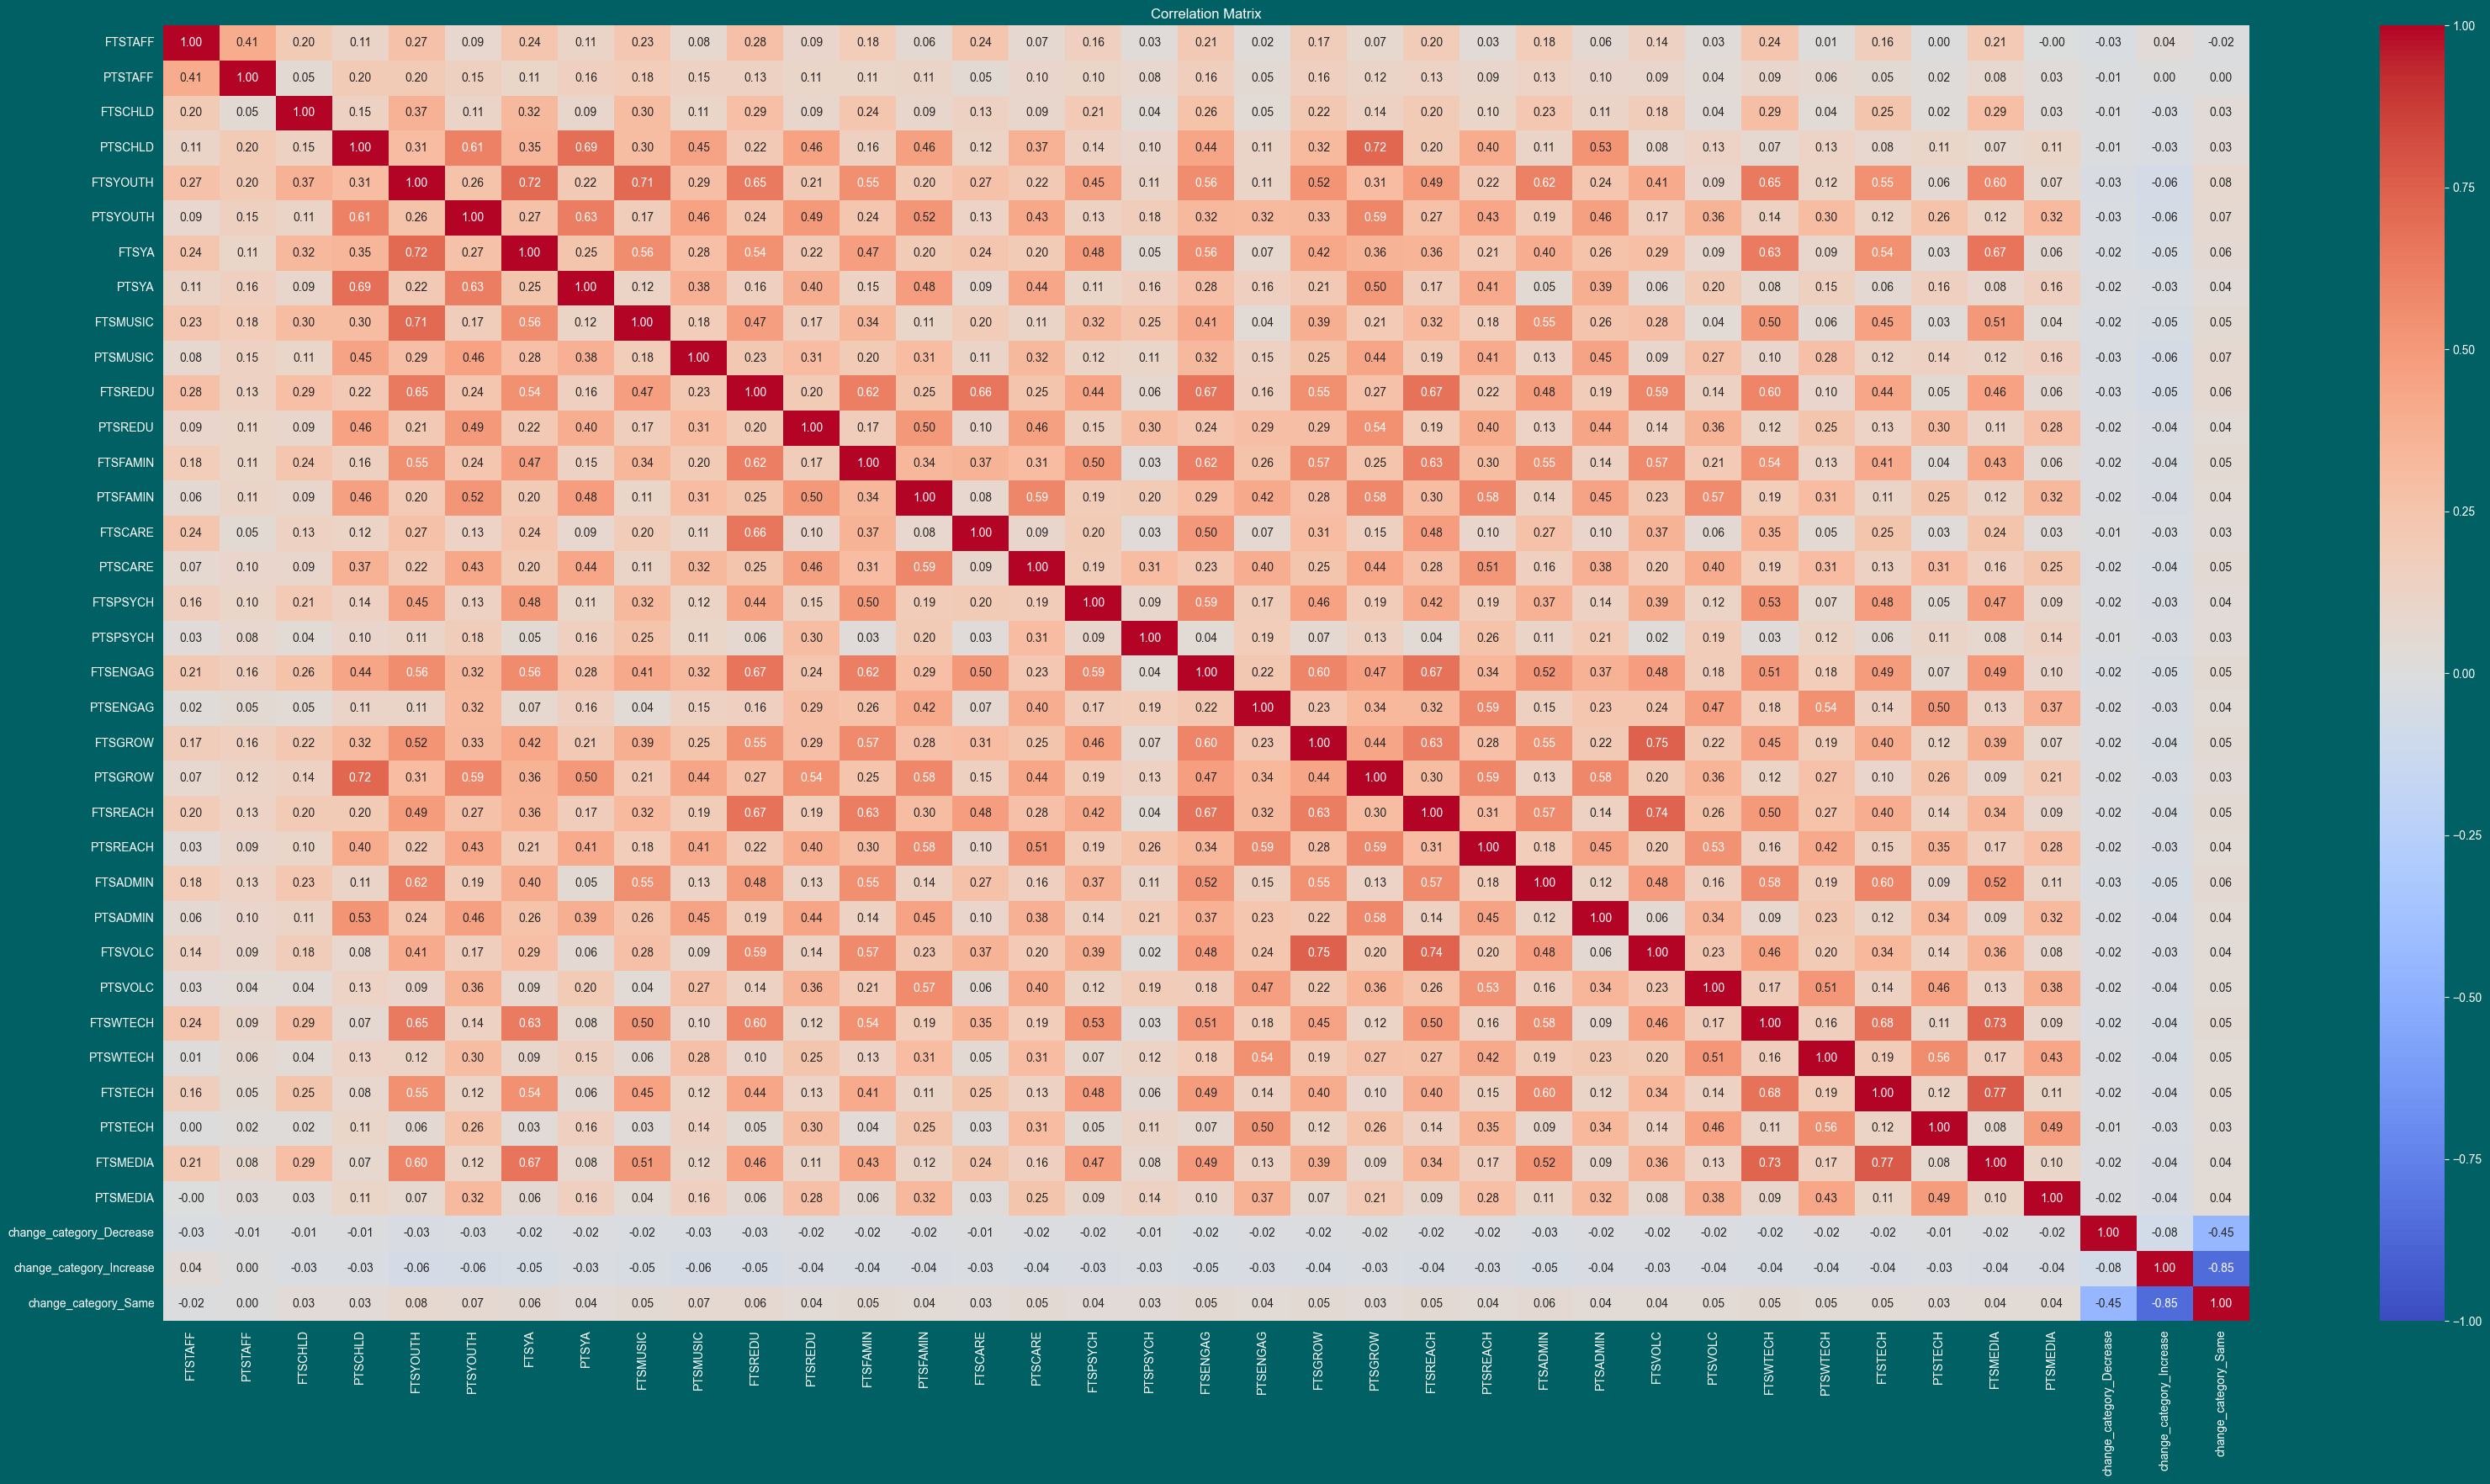

In [10]:
# Perform correlation analysis
correlation_matrix = df_staffing_encoded.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

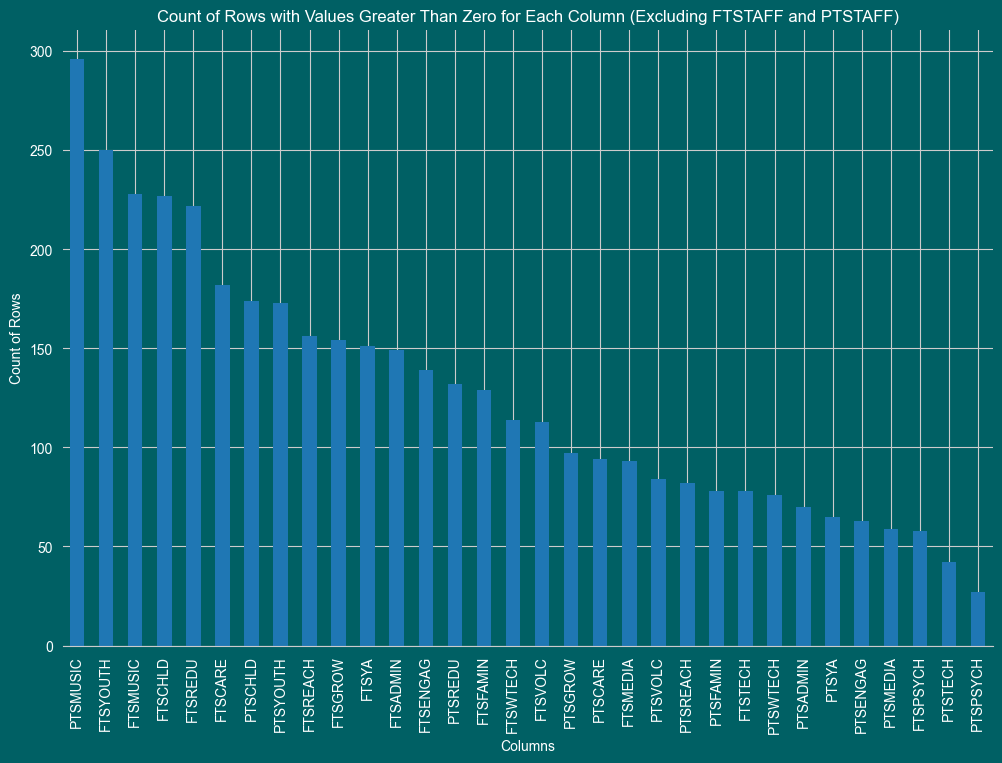

In [11]:
# Exclude 'FTSTAFF' and 'PTSTAFF' from the analysis
columns_for_plot = [col for col in columns_to_replace if col not in ['FTSTAFF', 'PTSTAFF']]

# Calculate the count of rows with a value greater than zero for each column
count_greater_than_zero = (df_staffing[columns_for_plot] > 0).sum().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
count_greater_than_zero.plot(kind='bar')
plt.title('Count of Rows with Values Greater Than Zero for Each Column (Excluding FTSTAFF and PTSTAFF)')
plt.xlabel('Columns')
plt.ylabel('Count of Rows')
plt.xticks(rotation=90)
plt.show()

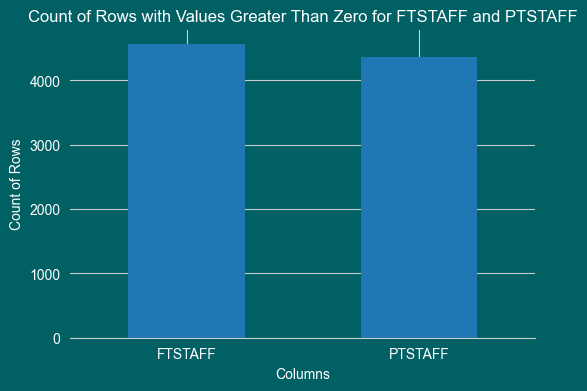

In [12]:
# Calculate the count of rows with a value greater than zero for FTSTAFF and PTSTAFF
count_greater_than_zero_staff = (df_staffing[['FTSTAFF', 'PTSTAFF']] > 0).sum()

# Plot the results for FTSTAFF and PTSTAFF
plt.figure(figsize=(6, 4))
count_greater_than_zero_staff.plot(kind='bar')
plt.title('Count of Rows with Values Greater Than Zero for FTSTAFF and PTSTAFF')
plt.xlabel('Columns')
plt.ylabel('Count of Rows')
plt.xticks(rotation=0)
plt.show()

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [13]:
# Hypothesis Testing using Chi-Squared Test
significant_columns = []
p_values = []

for column in columns_to_replace:
    contingency_table = pd.crosstab(df_staffing[column], df_staffing['change_category'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    p_values.append(p)
    if p < 0.05:
        significant_columns.append(column)

# Summarize Results
results = pd.DataFrame({'Column': columns_to_replace, 'p-value': p_values})
significant_results = results[results['p-value'] < 0.05]

# Sort the significant results by p-value in descending order
significant_results_sorted = significant_results.sort_values(by='p-value', ascending=True)

print("Significant predictors at alpha = 0.05:")
print(significant_results)

Significant predictors at alpha = 0.05:
      Column   p-value
2    FTSCHLD  0.004508
3    PTSCHLD  0.001093
4   FTSYOUTH  0.000007
5   PTSYOUTH  0.000398
6      FTSYA  0.005994
8   FTSMUSIC  0.000129
9   PTSMUSIC  0.000091
10   FTSREDU  0.002969
11   PTSREDU  0.044417
14   FTSCARE  0.017336
24  FTSADMIN  0.015681


C:\Users\natha\AppData\Local\Temp\ipykernel_27028\3290074134.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Column', y='p-value', data=significant_results_sorted, palette='viridis')


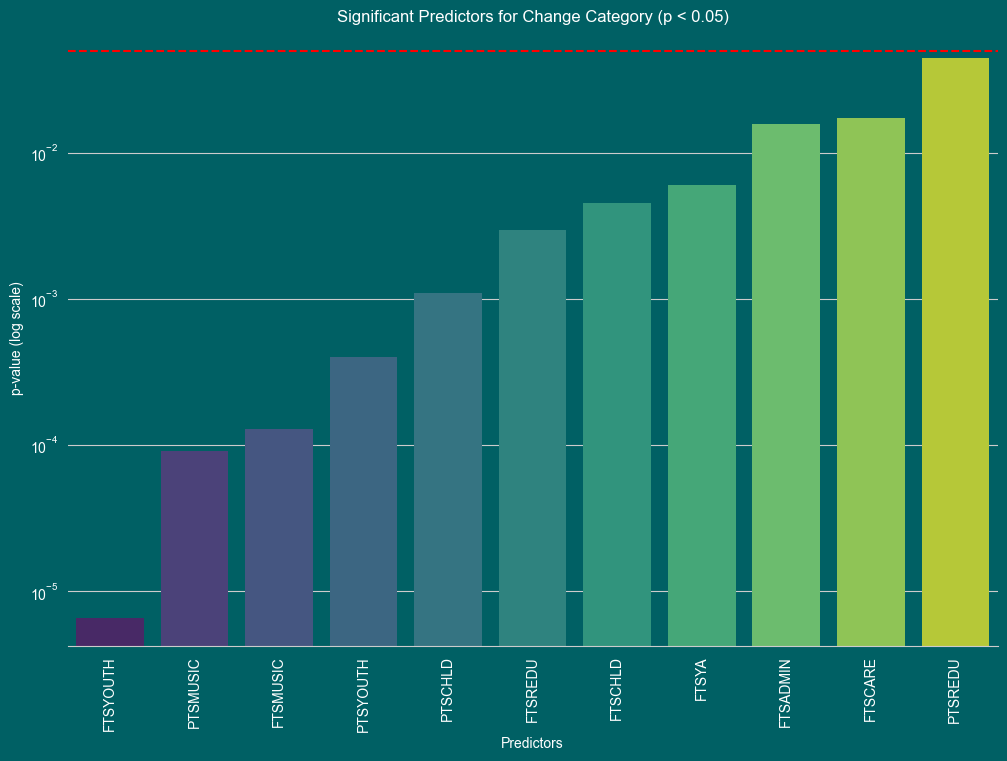

In [14]:
# Plot the significant results
plt.figure(figsize=(12, 8))
sns.barplot(x='Column', y='p-value', data=significant_results_sorted, palette='viridis')
plt.yscale('log')
plt.xlabel('Predictors')
plt.ylabel('p-value (log scale)')
plt.title('Significant Predictors for Change Category (p < 0.05)')
plt.xticks(rotation=90)
plt.axhline(y=0.05, color='r', linestyle='--')
plt.show()

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

In [15]:
# Prepare features and target
target_columns = ['change_category_Decrease', 'change_category_Increase', 'change_category_Same']
X = df_staffing_encoded.drop([col for col in target_columns if col in df_staffing_encoded.columns], axis=1)

# Convert one-hot encoded target back to single column of labels
y_columns = [col for col in target_columns if col in df_staffing_encoded.columns]
y = df_staffing_encoded[y_columns].idxmax(axis=1).apply(lambda x: x.replace('change_category_', ''))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000, multi_class='ovr')  # 'ovr' stands for one-vs-rest
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Decrease', 'Increase', 'Same'])

# Print unique values for debugging
print("Unique values in y_test:", y_test.unique())
print("Unique values in y_pred:", pd.Series(y_pred).unique())

# Generate the classification report with the correct labels
class_report = classification_report(y_test, y_pred, labels=['Decrease', 'Increase', 'Same'])

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Unique values in y_test: ['Same' 'Increase' 'Decrease']
Unique values in y_pred: ['Same' 'Increase']
Accuracy: 0.82
Confusion Matrix:
 [[   0    0   83]
 [   0    1  197]
 [   0    0 1319]]
Classification Report:
               precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00        83
    Increase       1.00      0.01      0.01       198
        Same       0.82      1.00      0.90      1319

    accuracy                           0.82      1600
   macro avg       0.61      0.34      0.30      1600
weighted avg       0.80      0.82      0.75      1600



c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Pre

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

In [16]:
# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Decrease', 'Increase', 'Same'])
class_report = classification_report(y_test, y_pred, target_names=['Decrease', 'Increase', 'Same'])

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.81
Confusion Matrix:
 [[   1    2   80]
 [   1   10  187]
 [   3   29 1287]]
Classification Report:
               precision    recall  f1-score   support

    Decrease       0.20      0.01      0.02        83
    Increase       0.24      0.05      0.08       198
        Same       0.83      0.98      0.90      1319

    accuracy                           0.81      1600
   macro avg       0.42      0.35      0.33      1600
weighted avg       0.72      0.81      0.75      1600



In [31]:
# Define the feature names and possible values
specified_features = ['FTSYOUTH', 'PTSMUSIC', 'FTSMUSIC', 'PTSYOUTH', 'PTSCHLD', 'FTSREDU', 'FTSYA', 'FTSADMIN', 'FTSCARE', 'PTSREDU']
all_features = ['FTSTAFF', 'PTSTAFF', 'FTSCHLD', 'PTSCHLD', 'FTSYOUTH', 'PTSYOUTH', 'FTSYA', 'PTSYA', 'FTSMUSIC', 'PTSMUSIC', 'FTSREDU', 'PTSREDU', 'FTSFAMIN', 'PTSFAMIN', 'FTSCARE', 'PTSCARE', 'FTSPSYCH', 'PTSPSYCH', 'FTSENGAG', 'PTSENGAG', 'FTSGROW', 'PTSGROW', 'FTSREACH', 'PTSREACH', 'FTSADMIN', 'PTSADMIN', 'FTSVOLC', 'PTSVOLC', 'FTSWTECH', 'PTSWTECH', 'FTSTECH', 'PTSTECH', 'FTSMEDIA', 'PTSMEDIA']
values = [0, 1]

# Generate all possible combinations of the specified features
combinations = list(product(values, repeat=len(specified_features)))
combinations_df = pd.DataFrame(combinations, columns=specified_features)

# Create a DataFrame with all features, initially set to 0
full_feature_df = pd.DataFrame(0, index=np.arange(len(combinations_df)), columns=all_features)

# Fill in the specified features with the generated combinations
full_feature_df[specified_features] = combinations_df

# Predict probabilities for each combination
probabilities = model.predict_proba(full_feature_df)

# Convert the probabilities to a DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=model.classes_)

# Add the combinations to the DataFrame for easy reference
full_feature_df['Combination'] = combinations_df.apply(lambda row: ', '.join(row.astype(str)), axis=1)
probabilities_df = pd.concat([full_feature_df[['Combination']], probabilities_df], axis=1)

# Melt the DataFrame for better plotting
melted_heatmap_df = probabilities_df.melt(id_vars='Combination', var_name='Category', value_name='Probability')

# Correct way to pivot the DataFrame
heatmap_pivot = melted_heatmap_df.pivot(index='Combination', columns='Category', values='Probability')

# Plot
#plt.figure(figsize=(12, 8))
#sns.heatmap(heatmap_pivot, annot=False, cmap='coolwarm', linewidths=.5)
#plt.title('Probabilities of Each Category for Feature Combinations')
#plt.show()

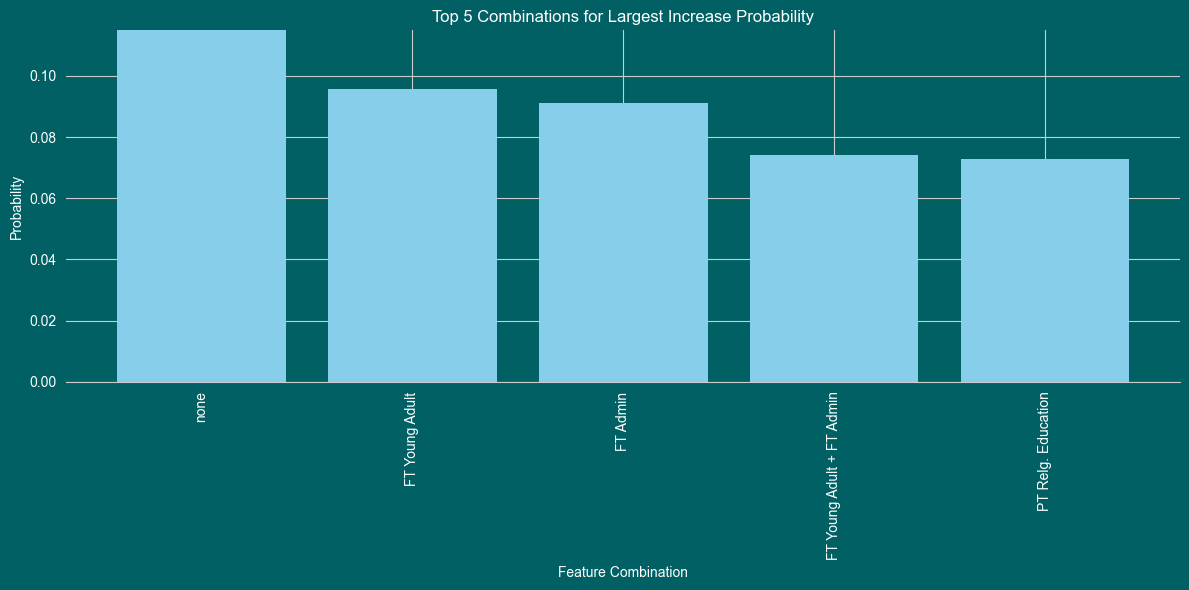

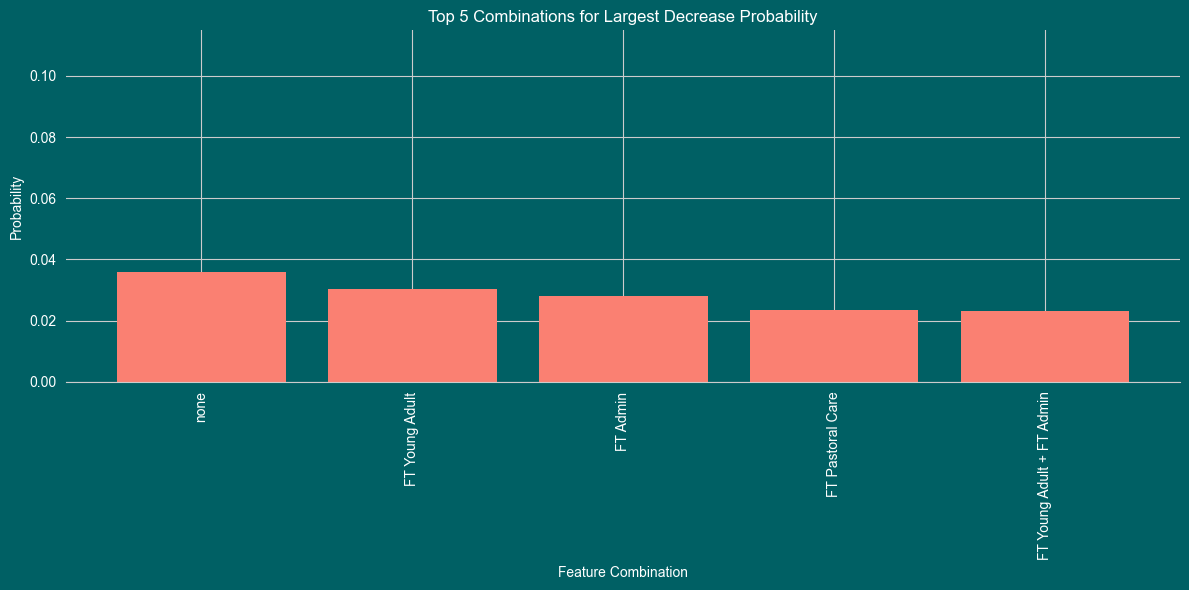

In [32]:
# Prepare data for plotting
top_increase_combinations = top_increase[['Combination', 'Increase']]
top_decrease_combinations = top_decrease[['Combination', 'Decrease']]

# Define custom x-axis labels for each plot
increase_labels = ['none', 'FT Young Adult', 'FT Admin', 'FT Young Adult + FT Admin', 'PT Relg. Education']
decrease_labels = ['none', 'FT Young Adult', 'FT Admin', 'FT Pastoral Care', 'FT Young Adult + FT Admin']

# Find the common y-axis limit for both plots
max_increase_prob = top_increase_combinations['Increase'].max()
max_decrease_prob = top_decrease_combinations['Decrease'].max()
y_limit = max(max_increase_prob, max_decrease_prob)  # Use the larger of the two maximums

# Plot for the top 5 combinations with the largest increase probability
plt.figure(figsize=(12, 6))
plt.bar(top_increase_combinations['Combination'], top_increase_combinations['Increase'], color='skyblue')
plt.xticks(ticks=range(len(increase_labels)), labels=increase_labels, rotation=90)
plt.title('Top 5 Combinations for Largest Increase Probability')
plt.xlabel('Feature Combination')
plt.ylabel('Probability')
plt.ylim(0, y_limit)  # Set y-axis limit
plt.tight_layout()
plt.show()

# Plot for the top 5 combinations with the largest decrease probability
plt.figure(figsize=(12, 6))
plt.bar(top_decrease_combinations['Combination'], top_decrease_combinations['Decrease'], color='salmon')
plt.xticks(ticks=range(len(decrease_labels)), labels=decrease_labels, rotation=90)
plt.title('Top 5 Combinations for Largest Decrease Probability')
plt.xlabel('Feature Combination')
plt.ylabel('Probability')
plt.ylim(0, y_limit)  # Set y-axis limit
plt.tight_layout()
plt.show()

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.